This notebook performs a simple simulation of mitotic division.  Gene regulation is assumed to produce the same statistics as a random distribution.

In [46]:
from typing import Iterable

import numpy as np
import matplotlib.pyplot as plt

from pylineage.multi_lineage_simulator import MultiLineageSimulator

from pylineage.cell import Cell
from pylineage.state import State
from pylineage.node import TreeNode

In [55]:
def divide(cell):
    exp = cell.state.expression
    for _ in range(2):
        cell.create_child(
            State(expression=exp + np.random.normal(size=len(exp)))
        )

def divide_leaves(root):
    # We must first collect leaves in a list to prevent infinite recursion
    for leaf in list(root.leaves()):
        divide(leaf)
        
def grow_lineage(root, number_of_generations):
    for _ in range(number_of_generations):
        divide_leaves(root)
        
def cells_expression(root):
    return np.vstack([cell.expression for cell in root.descendants()])
        
def leaves_expression(root):
    return np.vstack([leaf.expression for leaf in root.leaves()])
        
def estimate_expression_from_leaves(root):
    return np.mean(leaves_expression(root), axis=0)

def estimated_expression(root):
    return [estimate_expression_from_leaves(cell)
            for cell in root.descendants()]

def estimation_error(root):
    return 1 - np.corrcoef(estimate_expression_from_leaves(root), root.expression)[0, 1]**2

In [61]:
N_GENERATIONS = 10
N_GENES = 2000
root = Cell(State(expression=np.zeros(N_GENES)))
root.lineage = TreeNode()
grow_lineage(root, N_GENERATIONS)

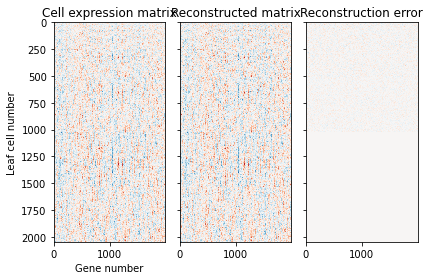

In [62]:
fig, (lax, cax, rax) = plt.subplots(ncols=3, sharey=True)

real = cells_expression(root)
estimated = estimated_expression(root)
difference = estimated - real

vmin = np.min(real)
vmax = np.max(real)

def draw_expression_matrix(ax, matrix):
    ax.imshow(matrix,
              aspect='auto',
              interpolation='none',
              cmap='RdBu',
              vmin=vmin, 
              vmax=vmax)

lax.set_title('Cell expression matrix')
cax.set_title('Reconstructed matrix')
rax.set_title('Reconstruction error')

draw_expression_matrix(lax, real)
draw_expression_matrix(cax, estimated)
draw_expression_matrix(rax, difference)

lax.set_xlabel('Gene number')
lax.set_ylabel('Leaf cell number')
fig.tight_layout()

In [63]:
depths = range(max(leaf.lineage.depth for leaf in root.leaves()) + 1)
error_per_depth = [[] for _ in depths]
for cell in root.descendants():
    error_per_depth[cell.lineage.depth].append(estimation_error(cell))

/Users/stankerstjens/.pyenv/versions/3.10.3/envs/constructive-connectomics/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/stankerstjens/.pyenv/versions/3.10.3/envs/constructive-connectomics/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Text(0, 0.5, 'Reconstruction error (1-correlation)')

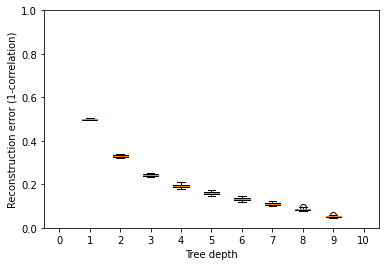

In [64]:
plt.boxplot(error_per_depth, positions=depths);
plt.ylim([0, 1])
plt.xlabel('Tree depth')
plt.ylabel('Reconstruction error (1-correlation)')